# TV regularization

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import pylops

from scipy.sparse import csr_matrix, vstack, rand
from scipy.linalg import lstsq, solve, pinv
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from scipy.sparse.linalg import cg, lsqr

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import SplitBregman as SplitBregman_f

In this notebook we will use the *Split Bregman* solver to solve the following unconstrained least-squares problem with multiple L1 constraints:

$$ J =  \mu/2 ||\textbf{b} - \textbf{Ax} |||_2 + \sum_i ||\Phi_i(\textbf{x}) |||_1$$

More specifically we will limit ourselves to the case of $\Phi_i$ being linear

$$ J =  \mu/2 ||\textbf{b} - \textbf{Ax} |||_2 + \sum_i ||\Phi_i \textbf{x} |||_1$$

Such a problem is first casted as an equivalent constrained least-squares problem

$$ J =  \mu/2 ||\textbf{b} - \textbf{Ax} |||_2 + \sum_i ||d_i|||_1  \quad subj.to \quad \Phi_i \textbf{x} = d_i$$

and then solved as an augmented unconstrained equivalent

$$ J = \sum_i ||d_i||_1 + \sum_i \lambda_i/2 ||d_i -  \Phi_i \textbf{x}|||_2 + \mu/2 ||\textbf{b} - \textbf{Ax} |||_2 $$

## Denoising

### 1D

$$ J =  \mu/2 ||\textbf{y} - \textbf{x} |||_2 +  ||\nabla \textbf{x}|||_1$$

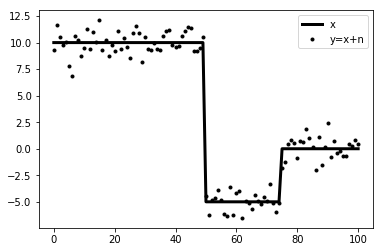

In [2]:
nx = 101
x = np.zeros(nx)
x[:nx//2] = 10
x[nx//2:3*nx//4] = -5

Dop = FirstDerivative(nx, edge=True)
D2op = SecondDerivative(nx, edge=True)
Iop = Identity(nx)

n = np.random.normal(0, 1, nx)
y = Iop*(x + n)
ymask = y.copy()
#y = Rop*(x + n)
#ymask = Rop.mask(x) + n

plt.figure()
plt.plot(x, 'k', lw=3, label='x')
plt.plot(ymask, '.k', label='y=x+n')
plt.legend()

In [3]:
def shrinkage(x, thresh):
    xabs = np.abs(x)
    return x/(xabs+1e-10) * np.maximum(xabs - thresh, 0)

def SplitBregman(y, Op, Dop, mu, lamda, niter, niterinner, tol=1e-3, tau=1., **kwargs_ls):
    nregs = len(Dop)
    b = [np.zeros(Op.shape[0])]*nregs
    d = [np.zeros(Op.shape[0])]*nregs
    xinv = np.zeros_like(np.zeros(Op.shape[1]))
    xold = np.inf * np.ones_like(np.zeros(Op.shape[1]))
    
    iiter = 0
    while np.linalg.norm(xinv - xold) > tol:
        xold = xinv
        iiter += 1
        for iiterinn in range(niterinner):
            # setup regularized problem
            xinv = RegularizedInversion(Op, Dop, y, dataregs=[d[ireg]-b[ireg] for ireg in range(nregs)], 
                                        epsRs=[np.sqrt(lamda[ireg]/2)/np.sqrt(mu/2) for ireg in range(nregs)],
                                        **kwargs_ls)
            #plt.figure()
            #plt.plot(xinv)
            #plt.figure()
            #plt.plot(Dop*xinv+b)
            d = [shrinkage(Dop[ireg]*xinv+b[ireg], lamda[ireg]) for ireg in range(nregs)]
            #plt.figure()
            #plt.plot(d)
            
        b = [b[ireg]+ tau*(Dop[ireg]*xinv - d[ireg]) for ireg in range(nregs)]
        if iiter > niter:
            break
    return xinv, iiter-1

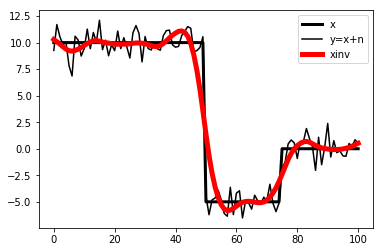

In [4]:
lamda = 1e2
xinv = RegularizedInversion(Iop, [D2op], y, epsRs=[np.sqrt(lamda/2)],
                            **dict(iter_lim=30))

plt.figure()
plt.plot(x, 'k', lw=3, label='x')
plt.plot(ymask, 'k', label='y=x+n')
plt.plot(xinv, 'r', lw=5, label='xinv')
plt.legend()

50


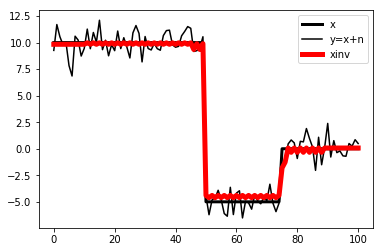

In [5]:
mu = 0.01
lamda = 0.25
niter = 50
niterinner = 3

xinv, niter = SplitBregman(y, Iop, [Dop], mu, [lamda], niter, niterinner, tol=1e-4, tau=1.,
                           **dict(iter_lim=30, damp=1e-10))
print(niter)

plt.figure()
plt.plot(x, 'k', lw=3, label='x')
plt.plot(ymask, 'k', label='y=x+n')
plt.plot(xinv, 'r', lw=5, label='xinv')
plt.legend();

50


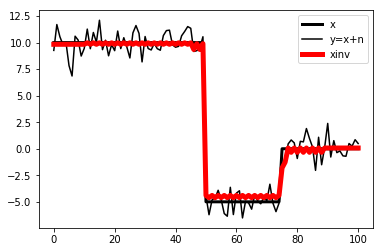

In [6]:
xinv_f, niter_f = SplitBregman_f(Iop, [Dop], y, niter, niterinner, mu=mu, epsRL1s=[lamda], 
                             tol=1e-4, tau=1., **dict(iter_lim=30, damp=1e-10))
print(niter)

plt.figure()
plt.plot(x, 'k', lw=3, label='x')
plt.plot(ymask, 'k', label='y=x+n')
plt.plot(xinv_f, 'r', lw=5, label='xinv')
plt.legend();

### 2D

$$ J =  \mu/2 ||\textbf{y} - \textbf{x} |||_2 +  ||\nabla_x \textbf{x}|||_1  +  ||\nabla_y \textbf{x}|||_1$$

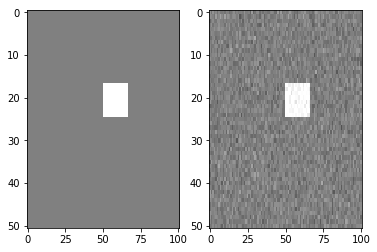

In [7]:
ny, nx = 51, 101
x = np.zeros((ny, nx))
x[ny//3:ny//2, nx//2:2*nx//3] = 1

Iop = Identity(ny*nx)
Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=True),
       FirstDerivative(ny*nx, dims=(ny, nx), dir=1, edge=True)]
D2op = Laplacian(dims=(ny, nx), edge=True)

n = np.random.normal(0, 0.1, (ny, nx))
y = Iop*(x.flatten() + n.flatten())
y = y.reshape(ny, nx)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(y, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight');

50


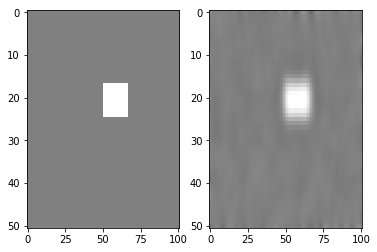

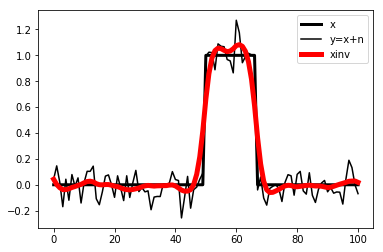

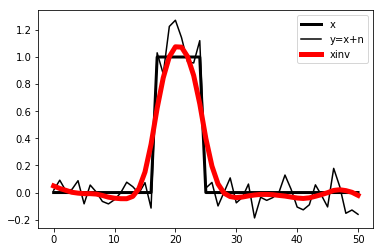

In [8]:
lamda = 1e1
xinv_sm = RegularizedInversion(Iop, [D2op], y.flatten(), epsRs=[np.sqrt(lamda/2)],
                            **dict(iter_lim=30))
xinv_sm = xinv_sm.reshape(ny, nx)
print(niter)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_sm, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(y[20], 'k', label='y=x+n')
plt.plot(xinv_sm[20], 'r', lw=5, label='xinv')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(y[:, 60], 'k', label='y=x+n')
plt.plot(xinv_sm[:, 60], 'r', lw=5, label='xinv')
plt.legend();

40


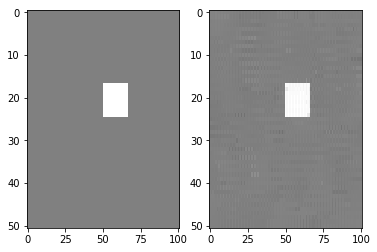

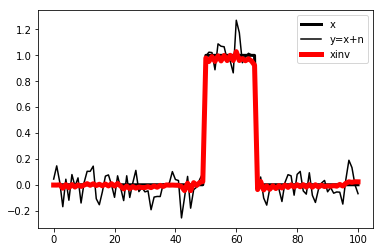

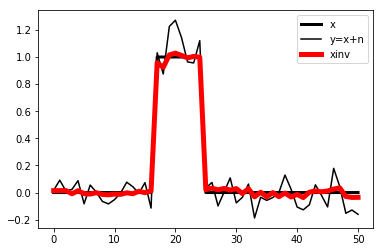

In [9]:
mu = 1.4
lamda = [0.3, 0.5]
niter = 40
niterinner = 1

xinv, niter = SplitBregman(y.flatten(), Iop, Dop, mu, lamda, niter, niterinner, tol=1e-6, tau=1.,
                           **dict(iter_lim=30, damp=1e-10))
xinv = xinv.reshape(ny, nx)
print(niter)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(y[20], 'k', label='y=x+n')
plt.plot(xinv[20], 'r', lw=5, label='xinv')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(y[:, 60], 'k', label='y=x+n')
plt.plot(xinv[:, 60], 'r', lw=5, label='xinv')
plt.legend();

And with the smooth solution as initial guess

20


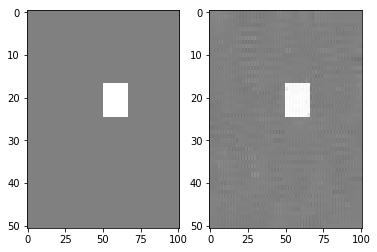

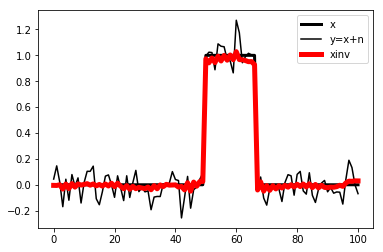

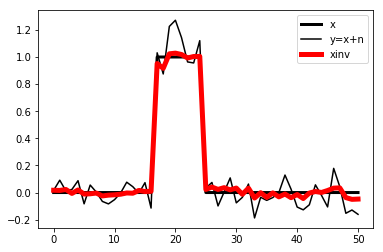

In [10]:
mu = 1.4
lamda = [0.3, 0.5]
niter = 20
niterinner = 1

xinv_f, niter_f = SplitBregman_f(Iop, Dop, y.flatten(), niter, niterinner, mu=mu, epsRL1s=lamda, 
                                 tol=1e-4, tau=1., x0=xinv_sm.flatten(), **dict(iter_lim=30, damp=1e-10))
xinv_f = xinv_f.reshape(ny, nx)
print(niter)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_f, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(y[20], 'k', label='y=x+n')
plt.plot(xinv_f[20], 'r', lw=5, label='xinv')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(y[:, 60], 'k', label='y=x+n')
plt.plot(xinv_f[:, 60], 'r', lw=5, label='xinv')
plt.legend();

Finally blocky in one direction and smooth in the other

50


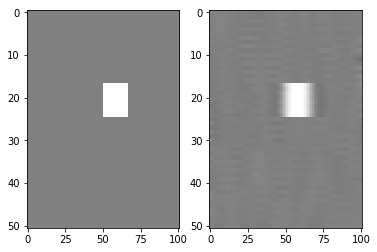

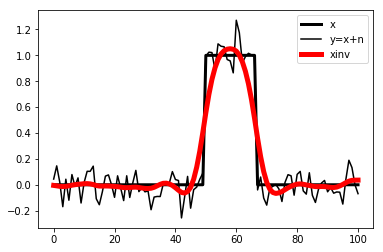

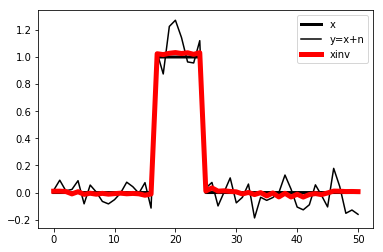

In [11]:
mu = 1.4
lamda = [0.3, 0.5]
niter = 50
niterinner = 1

Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=True),
       SecondDerivative(ny*nx, dims=(ny, nx), dir=1, edge=True)]

xinv_f, niter_f = SplitBregman_f(Iop, [Dop[0]], y.flatten(), niter, niterinner, mu=mu, epsRL1s=[lamda[0]],
                                 RegsL2=[Dop[1]], epsRL2s=[100*lamda[1]], tol=1e-4, tau=1., 
                                 x0=xinv_sm.flatten(), **dict(iter_lim=30, damp=1e-2))
xinv_f = xinv_f.reshape(ny, nx)
print(niter)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_f, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(y[20], 'k', label='y=x+n')
plt.plot(xinv_f[20], 'r', lw=5, label='xinv')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(y[:, 60], 'k', label='y=x+n')
plt.plot(xinv_f[:, 60], 'r', lw=5, label='xinv')
plt.legend();

## MRI imaging

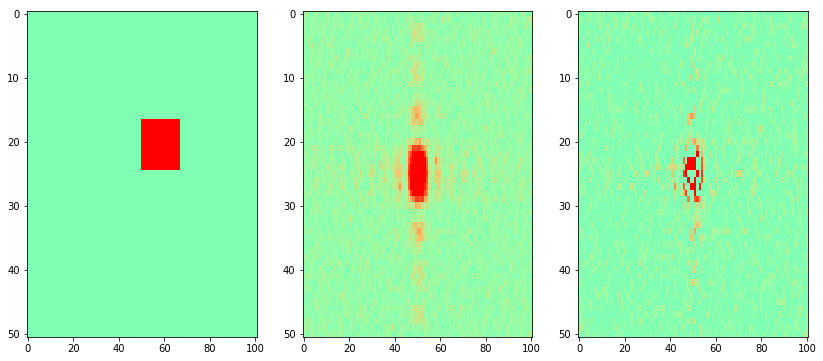

In [12]:
ny, nx = 51, 101
x = np.zeros((ny, nx))
x[ny//3:ny//2, nx//2:2*nx//3] = 1

perc_subsampling=0.4
nxsub=int(np.round(ny*nx*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(ny*nx))[:nxsub])
Rop = Restriction(ny*nx, iava, dtype=np.complex)
Fop = FFT2D(dims=(ny, nx))

n = np.random.normal(0, 0.1, (ny, nx))
y = Rop*Fop*(x.flatten() + n.flatten())
ymask = Rop.mask(Fop*(x.flatten() + n.flatten()))
yfft = Fop*(x.flatten() + n.flatten())
ymask = np.fft.fftshift(ymask.reshape(ny, nx))
yfft = np.fft.fftshift(yfft.reshape(ny,nx))

fig, axs = plt.subplots(1, 3, figsize=(14, 6))
axs[0].imshow(x, vmin=-1, vmax=1, cmap='rainbow')
axs[0].axis('tight')
axs[1].imshow(np.abs(yfft), vmin=-1, vmax=1, cmap='rainbow')
axs[1].axis('tight');
axs[2].imshow(np.abs(ymask), vmin=-1, vmax=1, cmap='rainbow')
axs[2].axis('tight');

99


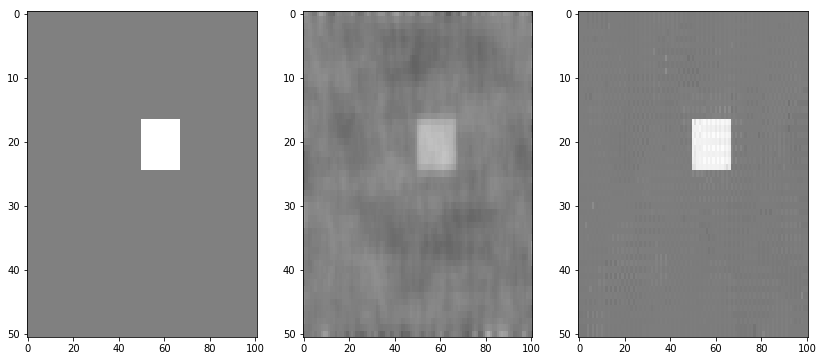

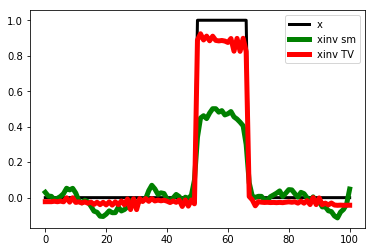

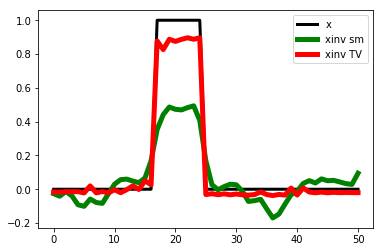

In [13]:
Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=True, dtype=np.complex),
       FirstDerivative(ny*nx, dims=(ny, nx), dir=1, edge=True, dtype=np.complex)]
D2op = Laplacian(dims=(ny, nx), edge=True, dtype=np.complex)


# L2
xinv_sm = RegularizedInversion(Rop*Fop, [D2op], y.flatten(), epsRs=[5e-1],
                               **dict(iter_lim=30))
xinv_sm = np.real(xinv_sm.reshape(ny, nx))

# TV
mu = 1.4
lamda = [0.3, 0.3]
niter = 100
niterinner = 1

xinv, niter = SplitBregman_f(Rop*Fop, Dop, y.flatten(), niter, niterinner, mu=mu, epsRL1s=lamda,
                             tol=1e-4, tau=1., **dict(iter_lim=30, damp=1e-5))
xinv = np.real(xinv.reshape(ny, nx))
print(niter)

fig, axs = plt.subplots(1, 3, figsize=(14, 6))
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_sm, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[2].imshow(xinv, vmin=-1, vmax=1, cmap='gray')
axs[2].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(xinv_sm[20], 'g', lw=5, label='xinv sm')
plt.plot(xinv[20], 'r', lw=5, label='xinv TV')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(xinv_sm[:, 60], 'g', lw=5, label='xinv sm')
plt.plot(xinv[:, 60], 'r', lw=5, label='xinv TV')
plt.legend();